Contributors: 
Peter Harmer,
Girish Dodda

In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\giris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import re

In [142]:
#Initializing
gpu_available = torch.cuda.is_available()
if gpu_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("GPU available: {}".format(gpu_available))

GPU available: False


In [4]:
#Load & check Data

colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('drive/My Drive/COMP SCI 539/bbc-news-data.csv', delimiter='\t')
else:
    data = pd.read_csv('bbc-news-data.csv', delimiter='\t')

data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


category    0
filename    0
title       0
content     0
dtype: int64


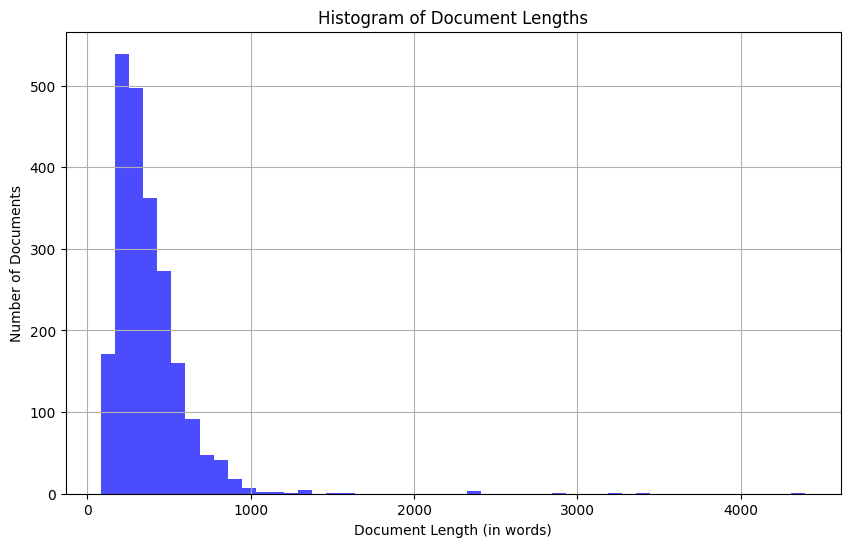

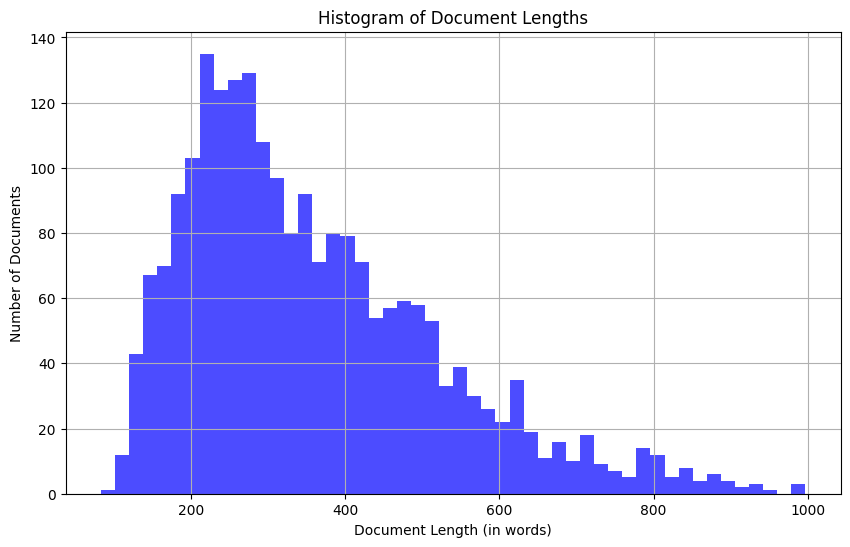

In [5]:
#Data Preprocessing

# Find and remove nulls
print(data.isnull().sum())

# Data to lowercase
data["title"] = data["title"].str.lower()
data["content"] = data["content"].str.lower()
# Remove and replace contractions
#Find more contraction in text and add
contraction_dict = {"can't":"cannot","didn't":"did not","aren't":"are not","she'd":"she would","he'd":"he would","they'd":"they would","they've":"they have",
"shouldn't":"should not","shouldn't've":"should not have","she'll":"she will","he'll":"he will","they'll":"they will"
}

def contraction_replacer(text):
    for word in text.split():
        if word in contraction_dict:
            text = text.replace(word, contraction_dict[word])
    return text

data["title"] = data["title"].apply(contraction_replacer)
data["content"] = data["content"].apply(contraction_replacer)

# Remove punctuation and numbers
#Find more punctuation in text and add

punctuation_numbers = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789'

def punctuation_numbers_remover(text):
    for punctuation in punctuation_numbers:
        text = text.replace(punctuation, '')
    return text

data["title"] = data["title"].apply(punctuation_numbers_remover)
data["content"] = data["content"].apply(punctuation_numbers_remover)

data.head()

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]


plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

# remove the outliers
MAX_CONTENT_LENGTH = 1000
MAX_TITLE_LENGTH = 10
# get the indices of the documents that have more than 1000 words
outliers = [idx for idx, length in enumerate(
    content_lengths) if length > MAX_CONTENT_LENGTH]

# remove the outliers from the data
data = data.drop(outliers, axis=0).reset_index(drop=True)

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

In [100]:
class Vocab:
    def __init__(self):
        self.word2index = {"PAD": 0, "UNK": 1}
        self.index2word = {0: "PAD", 1: "UNK"}
        self.word2count = {}
        self.n_words = 2 

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tokenize(self, sentence, seq_len=None):
        # Add Start Of Sentence token
        token_seq_idx = []

        # Tokenize each word in sentence
        for tkn in sentence.split():
            token_seq_idx.append(
                self.word2index[tkn if tkn in self.word2index else "UNK"])


        if seq_len is not None:
            if len(token_seq_idx) < seq_len:
                # Pad to desired length
                token_seq_idx += [self.word2index["PAD"]] * \
                    (seq_len - len(token_seq_idx))
            else:
                # Trim sentence to length
                token_seq_idx = token_seq_idx[:seq_len]

        return token_seq_idx

    def list2sentence(self, seq_ids):
        return " ".join([self.index2word[idx] for idx in seq_ids])


print("Creating vocab...")
vocab = Vocab()
for content in data["content"]:
    vocab.addSentence(content)

# Test it out
print("Number of words in vocab: {}".format(vocab.n_words))
# pick a random sequence from the data
random_idx = np.random.randint(0, len(data))
print("Original text: {}".format(data["content"][random_idx]))
# tokenize the text
tokenized_text = vocab.tokenize(data["content"][random_idx])
print("Tokenized text: {}".format(tokenized_text))
# convert back to text
converted_text = vocab.list2sentence(tokenized_text)
print("Converted text: {}".format(converted_text))

Creating vocab...
Number of words in vocab: 31568
Original text:  the new version of the band aid song do they know it's christmas has gone straight in at number one in the uk singles chart  the charity record is also tipped to be this year's christmas number one it features vocals from the likes of chris martin dido robbie williams and the sugababes the original version  which was the christmas number one in   sold  copies in its first week and  million in total it was released in the us and reached number  in the singles chart however band aid  is not going to be released in the us despite being sold in many countries around the world us record shops are stocking an import version of do they know it's christmas which is said to be selling very well in los angeles and new york  british stars who appear on the current recording such as dido and coldplay's chris martin are well known to music fans across the atlantic along with u frontman bono record company universal is responsible for

In [132]:
def create_dataloaders(batch_size):
    n = len(data)
    print("Creating dataloaders with {} samples...".format(n))
    content_seqs_ids = torch.zeros((n, MAX_CONTENT_LENGTH)).long()
    title_seqs_ids = torch.zeros((n, MAX_TITLE_LENGTH)).long()

    for idx, content in enumerate(data["content"]):
        # Tokenize and add to tensor
        content_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(content, seq_len=MAX_CONTENT_LENGTH))
        
    for idx, title in enumerate(data["title"]):
        title_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(title, seq_len=MAX_TITLE_LENGTH))

    # Split into training and testing
    train_sample_mask = torch.rand((n,)) > 0.3

    train_content_seqs_ids = content_seqs_ids[train_sample_mask]
    train_title_seqs_ids = title_seqs_ids[train_sample_mask]
    test_content_seqs_ids = content_seqs_ids[~train_sample_mask]
    test_title_seqs_ids = title_seqs_ids[~train_sample_mask]
    

    # Create train dataloader
    train_data = TensorDataset(train_content_seqs_ids.to(
        device), train_title_seqs_ids.to(device))
    train_dataloader = DataLoader(
        train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    # Create test dataloader
    test_data = TensorDataset(test_content_seqs_ids.to(
        device), test_title_seqs_ids.to(device))
    test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=batch_size)

    return train_dataloader, test_dataloader


# Test the dataloader
train_dataloader, test_dataloader = create_dataloaders(32)
for cont, titl in train_dataloader:
    print('Batch | cont =', cont.shape, '| titl =', titl.shape)
    print('First content: ', vocab.list2sentence(cont[0].tolist()))
    print('First title:', vocab.list2sentence(titl[0].tolist()))
    break

Creating dataloaders with 2204 samples...
Batch | cont = torch.Size([32, 1000]) | titl = torch.Size([32, 10])
First content:  conchita martinez won her first title in almost five years with victory over annalena groenefeld at the volvo women's open in pattaya thailand the yearold spaniard came through for her first title since berlin in it feels really good said martinez who is playing her last season on the tour to come through like that in an important match feels good it's been nearly five years and i did not think i could do it groenefeld was the more powerful player but could not match her opponent's relentless accuracy it was my first final a new experience said the german i think she played a good match a tough match but i tried to stay in there i think the whole week was good for me PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PA

In [111]:
sentence = 'the fat cat sat on the white hat with a big brown bat'
seq = torch.tensor([vocab.word2index[w]
                      for w in sentence.split()]).unsqueeze(0)
print(seq.shape)

torch.Size([1, 13])


In [112]:
class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout_rate=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.rnn = nn.LSTM(input_size=d_model, hidden_size=d_model,
                           num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        # Shape `(batch_size, seq_len, d_model)`.
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs  # Shape `(batch_size, seq_len, d_model)`.
    

# Example usage
rnn_encoder = RNNEncoder(vocab_size=vocab.n_words,
                         d_model=512, num_layers=3, dropout_rate=0.1).to(device)
print('Batch of Contents:', seq.shape)
print('Output of RNN Encoder:', rnn_encoder(seq.to(device)).shape)

Batch of Contents: torch.Size([1, 13])
Output of RNN Encoder: torch.Size([1, 13, 512])


In [113]:
class ExtractiveSummarizer(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout_rate=0.1, threshold=0.5, sum_len = 10, pad_token = 0):
        super().__init__()
        self.encoder = RNNEncoder(
            vocab_size, d_model, num_layers, dropout_rate)
        self.scoring_layer = nn.Linear(d_model, 1)
        self.threshold = nn.Parameter(torch.tensor(threshold))
        self.sum_len = sum_len
        self.pad_token = pad_token

    def forward(self, x):
        # Encoder outputs
        # Shape `(batch_size, seq_len, d_model)`.
        encoder_outputs = self.encoder(x)

        # Scoring each word
        # Shape `(batch_size, seq_len)`.
        scores = self.scoring_layer(encoder_outputs).squeeze(-1)
        selected = scores > self.threshold

        return scores, selected


summarizer = ExtractiveSummarizer(vocab_size=vocab.n_words, d_model=512, num_layers=3, dropout_rate=0.1, threshold=0.6, sum_len=MAX_TITLE_LENGTH, pad_token=vocab.word2index["PAD"]).to(device)

# Get the scores and selected words
scores, selected = summarizer(seq)

# Print the results
print("Scores:\n", scores)
print("Selected (Binary Mask):\n", selected)

Scores:
 tensor([[-0.0400, -0.0468, -0.0509, -0.0531, -0.0520, -0.0537, -0.0547, -0.0548,
         -0.0552, -0.0547, -0.0536, -0.0499, -0.0517]],
       grad_fn=<SqueezeBackward1>)
Selected (Binary Mask):
 tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False]])


In [114]:
def selectedToSummary(selected, scores, x, sum_len, pad_token):
    top_scores, top_indices = torch.topk(
        scores, k=sum_len, dim=-1, sorted=False)
    # Initialize an empty tensor for the summary indices

    summary_tokens = torch.full((x.size(
        0), sum_len), fill_value=pad_token, dtype=torch.long, device=x.device)
    # Fill in the indices of the top scoring words

    for i in range(x.size(0)):  # Loop over batch
        # Number of selected words or sum_len
        length = min(sum_len, (selected[i]).sum().item())
        summary_tokens[i, :length] = top_indices[i, :length]

    return summary_tokens

def summaryToSelected(summary, x, pad_idx):
    selected = torch.zeros_like(x, dtype=torch.bool)

    # Loop through all batches
    for i in range(x.size(0)):
        for j in range(summary.size(1)):
            if(summary[i, j] != pad_idx):
                # find the index of the summary token in the original sequence
                idx = (x[i] == summary[i, j]).nonzero(as_tuple=True)[0]
                selected[i, idx] = True

    return selected

# Test the functions
summary_tokens = selectedToSummary(selected, scores, seq, MAX_TITLE_LENGTH, vocab.word2index["PAD"])
print("Summary Tokens:\n", summary_tokens)
print("Summary:\n", vocab.list2sentence(summary_tokens[0].tolist()))


# Test the functions
summary_tokens = vocab.tokenize(data["title"][random_idx], seq_len=MAX_TITLE_LENGTH)
summary_tokens = torch.tensor(summary_tokens).unsqueeze(0)

selected = summaryToSelected(summary_tokens, seq, vocab.word2index["PAD"])
print("Summary Tokens:\n", summary_tokens)
print("Selected:\n", selected)

Summary Tokens:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Summary:
 PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Summary Tokens:
 tensor([[14032,  1120,  2044,  9440,    11,  1340,     0,     0,     0,     0]])
Selected:
 tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False]])


In [115]:
#Hyperparameters
dropout = 0.1
hidden_dim = 256
num_layers = 2
threshold = 0.5
lr= 0.01
epochs = 10
summation_length = MAX_TITLE_LENGTH

In [146]:
import os
import torch
import torch.nn as nn

import torch.optim as optim
import matplotlib.pyplot as plt


def fit(model, dataloader, optimizer, criterion, epochs, device):
    model.train()

    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        dataloader_size = len(dataloader)
        
        for i, batch in enumerate(dataloader):
            print(f'Batch {i}/{dataloader_size}', end='\r')
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            targets_selected = summaryToSelected(targets, inputs, vocab.word2index["PAD"]).to(device)

            # Forward pass
            scores, selected = model(inputs)
            probabilities = torch.sigmoid(scores)
            # print(targets.shape, outputs.shape)

            loss = criterion(probabilities, targets_selected.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
        torch.save(model.state_dict(), './model.pth')

    return loss_history


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        dataloader_size = len(dataloader)

        for i, batch in enumerate(dataloader):
            print(f'Batch {i}/{dataloader_size}', end='\r')

            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            targets_selected = summaryToSelected(targets, inputs, vocab.word2index["PAD"]).to(device)

            scores, selected = model(inputs)
            probabilities = torch.sigmoid(scores)

            # Same as in fit function, adjust loss calculation based on output and target format
            loss = criterion(probabilities, targets_selected.float())

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)

    return avg_loss# Example usage

# Assuming you have a dataloader for training and validation


batch_size = 32
train_dataloader, test_dataloader = create_dataloaders(batch_size)

load_model = True
keep_training = True

criterion = F.binary_cross_entropy

# Check if the model file exists
if os.path.exists("./model.pth") and load_model:
    print("Loading saved model...")
    model = ExtractiveSummarizer(vocab.n_words, hidden_dim, num_layers, dropout, threshold).to(device)
    model.load_state_dict(torch.load("./model.pth"))

    if keep_training:
        print("Continuing training...")
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_history = fit(model, train_dataloader, optimizer, criterion, epochs, device)
        torch.save(model.state_dict(), './model.pth')

else :
    print("Creating new model...")
    model = ExtractiveSummarizer(vocab_size=vocab.n_words, d_model=hidden_dim, num_layers=num_layers, dropout_rate=dropout, threshold=threshold).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss_history = fit(model, train_dataloader, optimizer, criterion, epochs, device)
    torch.save(model.state_dict(), './model.pth')


val_loss = evaluate(model, test_dataloader, criterion, device)
print(f'Validation loss: {val_loss:.4f}')

# Plotting
# plt.plot(train_loss_history, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Time')
# plt.legend()
# plt.show()

Creating dataloaders with 2204 samples...
Loading saved model...
Continuing training...
Epoch 1/10, Loss: 0.0437
Epoch 2/10, Loss: 0.0380
Epoch 3/10, Loss: 0.0346
Epoch 4/10, Loss: 0.0310
Epoch 5/10, Loss: 0.0286
Epoch 6/10, Loss: 0.0263
Epoch 7/10, Loss: 0.0234
Epoch 8/10, Loss: 0.0220
Epoch 9/10, Loss: 0.0215
Epoch 10/10, Loss: 0.0197
Validation loss: 0.0610


In [148]:
import random

def test_random_batches(dataloader, n):
    all_indices = list(range(len(dataloader)))
    random_idx = random.sample(all_indices, n)
    tests = [dataloader.dataset[i] for i in random_idx]

    for i, test in enumerate(tests):
        print(f'Test {i+1}/{n}')
        inputs, targets = test
        inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)

        scores, selected = model(inputs)
        probabilities = torch.sigmoid(scores)

        summary_tokens = selectedToSummary(selected, scores, inputs, summation_length, vocab.word2index["PAD"])

        print("Summary:\n", vocab.list2sentence(summary_tokens[0].tolist()))
        print("Target:\n", vocab.list2sentence(targets[0].tolist()))
        print("Input:\n", vocab.list2sentence(inputs[0].tolist()))
        print("")

test_random_batches(test_dataloader, 10)

Test 1/10
Summary:
 to view music and much PAD PAD PAD PAD PAD
Target:
 worldcom exboss launches defence PAD PAD PAD PAD PAD PAD
Input:
 lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness cynthia cooper worldcom's exhead of internal accounting alerted directors to irregular accounting practices at the us telecoms giant in her warnings led to the collapse of the firm following the discovery of an bn £bn accounting fraud mr ebbers has pleaded not guilty to charges of fraud and conspiracy prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates but ms cooper who now runs her own consulting business told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom's accounting in early and she said andersen had given a green